# Problem III: Text Classification with Recurrent Neural Networks

**Learning Objectives**

In this notebook, we explore **text classification** using **Recurrent Neural Networks (RNNs)**, one of the foundational architectures for processing sequential data. We will work with the **AG News** dataset, a popular benchmark for news article classification.

We will:
1. **Download** the AG News dataset from the internet
2. **Tokenize** text into sequences of tokens
3. **Build a vocabulary** mapping tokens to integer indices
4. **Transform** text into padded tensor sequences
5. **Organize** data using `Dataset` and `DataLoader` for efficient training
6. **Build and train** an RNN-based classifier
7. **Analyze** results

**Key Takeaway**: Understanding the text data pipeline (download → tokenize → build vocabulary → numericalize → pad → batch) is foundational. **Unlike** images, text requires additional preprocessing steps to convert discrete symbols into continuous representations suitable for neural networks.

# Step 1: Preparing the Data

## 1. Introduction: What is Text Classification?

**1.1 The Task**

**Text classification** is the task of assigning a label to a text document from a fixed set of categories. Mathematically, we seek a function:

$$f_{\theta}: \mathcal{X} \rightarrow \mathcal{Y}$$

where:
- $\mathcal{X}$ is the space of variable-length text sequences (sentences, paragraphs, documents)
- $\mathcal{Y} = \{0, 1, ..., K-1\}$ is the set of $K$ class labels
- $\theta$ are the learnable parameters of our model

For AG News:
- Text documents are news articles (title + description)
- There are $K = 4$ classes (World, Sports, Business, Sci/Tech)

**1.2 Why AG News?**

AG News is a widely-used benchmark dataset for text classification, constructed from news articles collected by an academic news search engine. It provides:

| Property | AG News |
|----------|---------------|
| Training samples | 120,000 |
| Test samples | 7,600 |
| Classes | 4 (World, Sports, Business, Sci/Tech) |
| Average text length | ~40 words |
| Difficulty | Moderate |
| Task | Multi-class classification |

**Comparison with Image Classification (Fashion-MNIST)**:

| Aspect | Image (Fashion-MNIST) | Text (AG News) |
|--------|----------------------|----------------|
| Input type | Fixed-size grid (28×28) | Variable-length sequence |
| Data representation | Continuous pixel values | Discrete tokens (words) |
| Spatial structure | 2D local correlations | 1D sequential dependencies |
| Preprocessing | Normalize pixels | Tokenize → Numericalize → Pad |
| Suitable architecture | CNN | RNN, LSTM, Transformer |

**1.3 Why Recurrent Neural Networks?**

Text is inherently **sequential**, the meaning of a word depends on the words that came before it. Consider:
- "The bank approved my loan" (financial institution)
- "I sat by the river bank" (edge of water)

Standard full-connected networks or CNNs treat inputs as fixed-size vectors or grids, **ignoring sequential dependencies**.

**RNNs exploit sequential structure** through:
1. **Temporal processing**: Process one token at a time, left to right
2. **Hidden state memory**: Maintain a hidden state $h_t$ that accumulates information from previous tokens
3. **Parameter sharing**: The same weights are applied at every time step

The core RNN equation:
$$h_t = \tanh(x_t W_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh})$$

This makes RNNs naturally suited for variable-length sequences like text. **For more details about RNN layers, please see Layers.ipynb**.

**1.4 The Text Classification Pipeline**

Unlike images, text requires several preprocessing steps:

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                         TEXT CLASSIFICATION PIPELINE                             │
└─────────────────────────────────────────────────────────────────────────────────┘

Raw Text           Tokenization         Numericalization        Embedding           RNN
─────────          ────────────         ────────────────        ─────────           ───
"I love ML"   →   ["I","love","ML"]  →    [5, 42, 137]     →   [e₅, e₄₂, e₁₃₇]  →  h_T
                                                                     ↓
                                                               Dense vectors       Final
                                                               (learnable)        hidden
                                                                                  state
```

Each step transforms the data:
1. **Tokenization**: Split text into tokens (words, subwords, or characters)
2. **Vocabulary building**: Create a mapping from tokens to integers
3. **Numericalization**: Convert tokens to integer indices
4. **Embedding**: Map integers to dense vectors (learnable)
5. **RNN processing**: Process sequence and extract final representation
6. **Classification**: Map final hidden state to class probabilities

## 2. Downloading the Data

**2.1 The Mathematical Setup**

Our dataset $\mathcal{D}$ consists of $N$ labeled examples:

$$\mathcal{D} = \{(\mathbf{s}^{(i)}, y^{(i)})\}_{i=1}^{N}$$

where:
- $\mathbf{s}^{(i)}$ is the $i$-th text string (variable-length sequence of characters)
- $y^{(i)} \in \{0, 1, 2, 3\}$ is the corresponding class label

**2.2 Manual Download Approach**

We download AG News directly from its source as CSV files. This approach is more robust than using `torchtext` (which has compatibility issues with newer PyTorch versions).

The AG News dataset is hosted on various mirrors. We'll download it programmatically:

**2.3 The AG News Classes**

| Label | Description | Example Topics |
|-------|-------------|----------------|
| 1 | World | International politics, global events |
| 2 | Sports | Football, basketball, Olympics |
| 3 | Business | Stock market, economy, companies |
| 4 | Sci/Tech | Technology, science discoveries |

**Note**: The original labels are 1-indexed (1, 2, 3, 4). We will convert them to 0-indexed (0, 1, 2, 3) for PyTorch compatibility.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import os
import urllib.request
import csv
import re
from collections import Counter

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Used device is {device}')

Used device is mps


In [2]:
# Define data directory
DATA_DIR = './data/ag_news'
os.makedirs(DATA_DIR, exist_ok=True)

# URLs for AG News dataset (hosted on GitHub mirror)
URLS = {
    'train': 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv',
    'test': 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'
}

def download_ag_news(data_dir, urls):
    """Download AG News dataset if not already present."""
    for split, url in urls.items():
        filepath = os.path.join(data_dir, f'{split}.csv')
        if not os.path.exists(filepath):
            print(f"Downloading {split} data...")
            urllib.request.urlretrieve(url, filepath)
            print(f"{split.capitalize()} data downloaded: {filepath}")
        else:
            print(f"{split.capitalize()} data already exists: {filepath}")
    return os.path.join(data_dir, 'train.csv'), os.path.join(data_dir, 'test.csv')

print("="*60)
print("DOWNLOADING AG NEWS DATASET")
print("="*60)
print()

train_path, test_path = download_ag_news(DATA_DIR, URLS)
print("\nDownload complete!")

DOWNLOADING AG NEWS DATASET

Train data downloaded: ./data/ag_news/train.csv
Test data downloaded: ./data/ag_news/test.csv

Download complete!


In [4]:
# Load the CSV files
# AG News CSV format: label, title, description (no header)
train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'description'])
test_df = pd.read_csv(test_path, header=None, names=['label', 'title', 'description'])

print("="*60)
print("LOADING RAW DATA")
print("="*60)
print(f"\nTraining samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nColumns: {list(train_df.columns)}")

# Define class names
CLASS_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']

# Show a sample
sample = train_df.iloc[0]
print(f"\nSample entry:")
print(f"  Label: {sample['label']} ({CLASS_NAMES[sample['label']-1]})")
print(f"  Title: {sample['title']}")
print(f"  Description: {sample['description'][:50]}...")

LOADING RAW DATA

Training samples: 120,000
Test samples: 7,600

Columns: ['label', 'title', 'description']

Sample entry:
  Label: 3 (Business)
  Title: Wall St. Bears Claw Back Into the Black (Reuters)
  Description: Reuters - Short-sellers, Wall Street's dwindling\b...


In [5]:
# Examine class distribution
print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)

print("\nTraining Set:")
for label in sorted(train_df['label'].unique()):
    count = (train_df['label'] == label).sum()
    print(f"  {CLASS_NAMES[label-1]:10s} {count:,} samples ({100*count/len(train_df):.1f}%)")

print("\nTest Set:")
for label in sorted(test_df['label'].unique()):
    count = (test_df['label'] == label).sum()
    print(f"  {CLASS_NAMES[label-1]:10s} {count:,} samples ({100*count/len(test_df):.1f}%)")

print("\nDataset is perfectly balanced!")

CLASS DISTRIBUTION

Training Set:
  World      30,000 samples (25.0%)
  Sports     30,000 samples (25.0%)
  Business   30,000 samples (25.0%)
  Sci/Tech   30,000 samples (25.0%)

Test Set:
  World      1,900 samples (25.0%)
  Sports     1,900 samples (25.0%)
  Business   1,900 samples (25.0%)
  Sci/Tech   1,900 samples (25.0%)

Dataset is perfectly balanced!


## 3. Tokenization

**3.1 What is Tokenization?**

Tokenization is the process of splitting text into discrete units called **tokens**. There are several strategies:

| Strategy | Example | Pros | Cons |
|----------|---------|------|------|
| **Word-level** | "I love ML" → ["I", "love", "ML"] | Intuitive, captures meaning | Large vocabulary, OOV problem |
| **Character-level** | "I love" → ["I", " ", "l", "o", "v", "e"] | Small vocabulary, no OOV | Loses word meaning, long sequences |
| **Subword** | "loving" → ["lov", "ing"] | Balance of both | Requires training |

We'll use **word-level tokenization** with simple preprocessing:
1. Convert to lowercase
2. Remove punctuation
3. Split on whitespace

**3.2 Handling Unknown Words (OOV)**

Words not seen during training are called **Out-of-Vocabulary (OOV)** words. We handle them with a special `<unk>` token.

**3.3 Special Tokens**

| Token | Index | Purpose |
|-------|-------|--------|
| `<pad>` | 0 | Padding for batch alignment |
| `<unk>` | 1 | Unknown/OOV words |

In [6]:
def tokenize(text):
    """
    Simple word-level tokenizer.
    
    Steps:
    1. Convert to lowercase
    2. Remove non-alphanumeric characters (keep spaces)
    3. Split on whitespace
    4. Remove empty tokens
    
    Args:
        text: Input string
    
    Returns:
        List of tokens (words)
    """
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric (keep spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Split and filter empty
    tokens = [token for token in text.split() if token]
    return tokens

# Test the tokenizer
sample_text = train_df.iloc[0]['title']
sample_tokens = tokenize(sample_text)

print("="*60)
print("TOKENIZATION EXAMPLE")
print("="*60)
print(f"\nOriginal text:")
print(f'  "{sample_text}"')
print(f"\nAfter tokenization:")
print(f"  {sample_tokens}")
print(f"\nNumber of tokens: {len(sample_tokens)}")

TOKENIZATION EXAMPLE

Original text:
  "Wall St. Bears Claw Back Into the Black (Reuters)"

After tokenization:
  ['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters']

Number of tokens: 9


In [7]:
def combine_text(row):
    """
    Combine title and description into a single text.
    """
    title = str(row['title']) if pd.notna(row['title']) else ''
    description = str(row['description']) if pd.notna(row['description']) else ''
    return title + ' ' + description

# Combine title and description for all samples
train_df['text'] = train_df.apply(combine_text, axis=1)
test_df['text'] = test_df.apply(combine_text, axis=1)

print("="*60)
print("COMBINING TITLE AND DESCRIPTION")
print("="*60)

sample = train_df.iloc[0]
print(f"\nSample combined text:")
print(f"  Title: {sample['title']}")
print(f"  Description: {sample['description'][:50]}...")
print(f"\nCombined tokens (first 20):")
print(f"  {tokenize(sample['text'])[:20]}")

COMBINING TITLE AND DESCRIPTION

Sample combined text:
  Title: Wall St. Bears Claw Back Into the Black (Reuters)
  Description: Reuters - Short-sellers, Wall Street's dwindling\b...

Combined tokens (first 20):
  ['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'shortsellers', 'wall', 'streets', 'dwindlingband', 'of', 'ultracynics', 'are', 'seeing', 'green', 'again']


## 4. Building the Vocabulary

**4.1 What is a Vocabulary?**

A vocabulary is a mapping from tokens to integer indices:

$$\text{vocab}: \text{Token} \rightarrow \mathbb{Z}^+$$

For example:
```
{"<pad>": 0, "<unk>": 1, "the": 2, "a": 3, "is": 4, ...}
```

**4.2 Vocabulary Size Trade-off**

| Vocabulary Size | Pros | Cons |
|-----------------|------|------|
| Small (e.g., 5K) | Faster training, less memory | More `<unk>` tokens, loses information |
| Large (e.g., 100K) | Better coverage | Slower, more memory, rare words |

**Common Practice**: Keep the top $V$ most frequent words (e.g., $V = 25,000$).

**4.3 Building Process**

1. Tokenize all training texts
2. Count token frequencies
3. Keep top $V$ most frequent tokens
4. Assign indices (0 = `<pad>`, 1 = `<unk>`, 2+ = words by frequency)

In [8]:
# Count token frequencies from training data only
print("="*60)
print("BUILDING VOCABULARY")
print("="*60)

print("\nTokenizing training data...")
token_counter = Counter()

for text in train_df['text']:
    tokens = tokenize(text)
    token_counter.update(tokens)

print(f"Total tokens in training data: {sum(token_counter.values()):,}")
print(f"Unique tokens: {len(token_counter):,}")

# Show most common tokens
print("\nTop 10 most common tokens:")
for token, count in token_counter.most_common(10):
    print(f"  {token:10s}: {count:,}")

BUILDING VOCABULARY

Tokenizing training data...
Total tokens in training data: 4,489,931
Unique tokens: 102,169

Top 10 most common tokens:
  the       : 203,527
  to        : 119,026
  a         : 107,550
  of        : 97,908
  in        : 95,430
  and       : 68,852
  on        : 56,507
  for       : 50,168
  39s       : 31,218
  that      : 27,741


In [9]:
# Build vocabulary with size limit
MAX_VOCAB_SIZE = 25000  # Keep top 25K words

# Special tokens
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
PAD_IDX = 0
UNK_IDX = 1

class Vocabulary:
    """
    Vocabulary class for mapping tokens to indices and vice versa.
    
    Attributes:
        token2idx: Dict mapping tokens to indices
        idx2token: Dict mapping indices to tokens
        size: Number of tokens in vocabulary
    """
    def __init__(self, token_counter, max_size=None, special_tokens=None):
        """
        Build vocabulary from token counts.
        
        Args:
            token_counter: Counter object with token frequencies
            max_size: Maximum vocabulary size (excluding special tokens)
            special_tokens: List of (token, index) tuples for special tokens
        """
        self.token2idx = {}
        self.idx2token = {}
        
        # Add special tokens first
        if special_tokens:
            for token, idx in special_tokens:
                self.token2idx[token] = idx
                self.idx2token[idx] = token
        
        # Add most common tokens
        start_idx = len(self.token2idx)
        most_common = token_counter.most_common(max_size)
        
        for idx, (token, count) in enumerate(most_common, start=start_idx):
            self.token2idx[token] = idx
            self.idx2token[idx] = token
        
        self.size = len(self.token2idx)
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, token):
        """Get index for token, return UNK_IDX if not found."""
        return self.token2idx.get(token, UNK_IDX)
    
    def lookup_token(self, idx):
        """Get token for index."""
        return self.idx2token.get(idx, UNK_TOKEN)

# Build the vocabulary
special_tokens = [(PAD_TOKEN, PAD_IDX), (UNK_TOKEN, UNK_IDX)]
vocab = Vocabulary(token_counter, max_size=MAX_VOCAB_SIZE, special_tokens=special_tokens)

print("="*60)
print("VOCABULARY CREATED")
print("="*60)
print(f"\nVocabulary size: {len(vocab):,}")
print(f"  - Special tokens: 2 (<pad>, <unk>)")
print(f"  - Regular tokens: {MAX_VOCAB_SIZE:,}")

print("\nSpecial token indices:")
print(f"  {PAD_TOKEN} → {vocab[PAD_TOKEN]}")
print(f"  {UNK_TOKEN} → {vocab[UNK_TOKEN]}")

print("\nSample word indices:")
for word in ['the', 'to', 'a', 'of', 'in']:
    print(f"  {word} → {vocab[word]}")

VOCABULARY CREATED

Vocabulary size: 25,002
  - Special tokens: 2 (<pad>, <unk>)
  - Regular tokens: 25,000

Special token indices:
  <pad> → 0
  <unk> → 1

Sample word indices:
  the → 2
  to → 3
  a → 4
  of → 5
  in → 6


In [10]:
# Demonstrate numericalization
def numericalize(text, vocab):
    """
    Convert text to list of token indices.
    
    Args:
        text: Input string
        vocab: Vocabulary object
    
    Returns:
        List of integer indices
    """
    tokens = tokenize(text)
    return [vocab[token] for token in tokens]

# Test numericalization
sample_text = "Wall St. Bears Claw Back Into the Black"
sample_tokens = tokenize(sample_text)
sample_indices = numericalize(sample_text, vocab)

print("="*60)
print("NUMERICALIZATION EXAMPLE")
print("="*60)
print(f'\nOriginal text: "{sample_text}"')
print(f"\nTokens:  {sample_tokens}")
print(f"Indices: {sample_indices}")

print("\nToken-to-index mapping:")
for token, idx in zip(sample_tokens, sample_indices):
    print(f"  {token:5s} → {idx}")

NUMERICALIZATION EXAMPLE

Original text: "Wall St. Bears Claw Back Into the Black"

Tokens:  ['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black']
Indices: [399, 395, 1564, 14719, 101, 55, 2, 839]

Token-to-index mapping:
  wall  → 399
  st    → 395
  bears → 1564
  claw  → 14719
  back  → 101
  into  → 55
  the   → 2
  black → 839


## 5. Creating the Dataset

**5.1 PyTorch Dataset Class**

PyTorch's `Dataset` is an abstract class that represents a dataset. We need to implement:
- `__len__()`: Return the number of samples
- `__getitem__(idx)`: Return sample at index `idx`

**5.2 Handling Variable-Length Sequences**

Unlike images (fixed 28×28), text sequences have variable lengths. For batching, we need:
1. **Maximum length**: Truncate sequences longer than `max_length`
2. **Padding**: Pad shorter sequences with `<pad>` tokens to `max_length`

```
Before padding:              After padding (max_length=5):
─────────────────           ────────────────────────────
[1, 2, 3]                   [1, 2, 3, 0, 0]
[4, 5, 6, 7]                [4, 5, 6, 7, 0]
[8, 9]                      [8, 9, 0, 0, 0]
[1, 2, 3, 4, 5, 6, 7]       [1, 2, 3, 4, 5]  (truncated)
```

**5.3 Label Adjustment**

Original AG News labels are 1-indexed (1, 2, 3, 4). PyTorch expects 0-indexed labels (0, 1, 2, 3).

In [11]:
# Analyze text lengths to choose max_length
print("="*60)
print("TEXT LENGTH ANALYSIS")
print("="*60)

# Compute lengths for a sample of training data
sample_size = 10000
lengths = [len(tokenize(text)) for text in train_df['text'].iloc[:sample_size]]

print(f"\nSequence length statistics (in tokens):")
print(f"  Min:    {min(lengths)}")
print(f"  Max:    {max(lengths)}")
print(f"  Mean:   {np.mean(lengths):.1f}")
print(f"  Median: {np.median(lengths):.1f}")
print(f"  95th percentile: {np.percentile(lengths, 95):.1f}")

# Choose max_length based on analysis
MAX_LENGTH = 64  # Covers most sequences while limiting computation
print(f"\n→ Using max_length = {MAX_LENGTH} (covers ~85% of sequences without truncation)")

TEXT LENGTH ANALYSIS

Sequence length statistics (in tokens):
  Min:    11
  Max:    143
  Mean:   38.1
  Median: 38.0
  95th percentile: 56.0

→ Using max_length = 64 (covers ~85% of sequences without truncation)


In [12]:
class AGNewsDataset(Dataset):
    """
    PyTorch Dataset for AG News text classification.
    
    Handles:
    - Tokenization and numericalization
    - Padding/truncation to fixed length
    - Label conversion (1-indexed → 0-indexed)
    
    Attributes:
        texts: List of text strings
        labels: List of integer labels (0-indexed)
        vocab: Vocabulary object
        max_length: Maximum sequence length
    """
    
    def __init__(self, texts, labels, vocab, max_length=64):
        """
        Initialize the dataset.
        
        Args:
            texts: List of text strings
            labels: List of labels (1-indexed from AG News)
            vocab: Vocabulary object for numericalization
            max_length: Maximum sequence length (pad/truncate to this)
        """
        self.texts = texts
        self.labels = [label - 1 for label in labels]  # Convert to 0-indexed
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        """
        Get a single sample.
        
        Returns:
            text_tensor: LongTensor of shape (max_length,)
            label: Integer label (0-3)
            length: Original sequence length (before padding)
        """
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize and numericalize
        tokens = tokenize(text)
        indices = [self.vocab[token] for token in tokens]
        
        # Store original length (useful for packing sequences later)
        original_length = len(indices)
        
        # Truncate if too long
        if len(indices) > self.max_length:
            indices = indices[:self.max_length]
            original_length = self.max_length
        
        # Pad if too short
        padding_length = self.max_length - len(indices)
        indices = indices + [PAD_IDX] * padding_length
        
        # Convert to tensors
        text_tensor = torch.tensor(indices, dtype=torch.long)
        
        return text_tensor, label, original_length

print("AGNewsDataset class defined")

AGNewsDataset class defined


In [13]:
# Create datasets
print("="*60)
print("CREATING DATASETS")
print("="*60)

# Create full training dataset
full_train_dataset = AGNewsDataset(
    texts=train_df['text'].tolist(),
    labels=train_df['label'].tolist(),
    vocab=vocab,
    max_length=MAX_LENGTH
)

# Create test dataset
test_dataset = AGNewsDataset(
    texts=test_df['text'].tolist(),
    labels=test_df['label'].tolist(),
    vocab=vocab,
    max_length=MAX_LENGTH
)

print(f"\nFull training dataset: {len(full_train_dataset):,} samples")
print(f"Test dataset: {len(test_dataset):,} samples")

# Verify a sample
sample_text, sample_label, sample_length = full_train_dataset[0]
print(f"\nSample from training dataset:")
print(f"  Text tensor shape: {sample_text.shape}")
print(f"  Label: {sample_label} ({CLASS_NAMES[sample_label]})")
print(f"  Original length: {sample_length}")
print(f"  First 10 indices: {sample_text[:10].tolist()}")

CREATING DATASETS

Full training dataset: 120,000 samples
Test dataset: 7,600 samples

Sample from training dataset:
  Text tensor shape: torch.Size([64])
  Label: 2 (Business)
  Original length: 20
  First 10 indices: [399, 395, 1564, 14719, 101, 55, 2, 839, 24, 24]


## 6. Splitting and Loading Data

**6.1 Why Split Training into Train/Validation?**

Similar to the CNN exercise, we split the training data:

| Set | Purpose | Size |
|-----|---------|------|
| **Training** | Learn parameters | 96,000 (80%) |
| **Validation** | Tune hyperparameters, early stopping | 24,000 (20%) |
| **Test** | Final evaluation | 7,600 (provided) |

**6.2 DataLoader for Batching**

The `DataLoader` handles:
- Batching samples together
- Shuffling (for training)
- Parallel data loading

**6.3 Custom Collate Function**

We need a custom collate function to properly batch our data, including the sequence lengths.

In [14]:
# Split training data into train and validation
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

print("="*60)
print("SPLITTING TRAINING DATA")
print("="*60)
print(f"\nOriginal training set: {len(full_train_dataset):,} samples")
print(f"Split ratio: {TRAIN_RATIO:.0%} train / {1-TRAIN_RATIO:.0%} validation")

# Perform the split
generator = torch.Generator().manual_seed(42)  # For reproducibility
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=generator
)

print(f"\nAfter split:")
print(f"  Training:   {len(train_dataset):,} samples")
print(f"  Validation: {len(val_dataset):,} samples")
print(f"  Test:       {len(test_dataset):,} samples (separate)")

SPLITTING TRAINING DATA

Original training set: 120,000 samples
Split ratio: 80% train / 20% validation

After split:
  Training:   96,000 samples
  Validation: 24,000 samples
  Test:       7,600 samples (separate)


In [15]:
def collate_fn(batch):
    """
    Custom collate function for batching.
    
    Takes a list of (text_tensor, label, length) tuples and returns:
    - texts: Tensor of shape (batch_size, max_length)
    - labels: Tensor of shape (batch_size,)
    - lengths: Tensor of shape (batch_size,)
    
    Args:
        batch: List of tuples from AGNewsDataset.__getitem__
    
    Returns:
        Tuple of (texts, labels, lengths) tensors
    """
    texts, labels, lengths = zip(*batch)
    
    # Stack into tensors
    texts = torch.stack(texts, dim=0)       # (batch_size, max_length)
    labels = torch.tensor(labels, dtype=torch.long)  # (batch_size,)
    lengths = torch.tensor(lengths, dtype=torch.long)  # (batch_size,)
    
    return texts, labels, lengths

print("Collate function defined")

Collate function defined


In [18]:
# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # Shuffle training data each epoch
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if device == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle validation
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if device == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # Don't shuffle test
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if device == 'cuda' else False
)

print("="*60)
print("DATALOADER CONFIGURATION")
print("="*60)
print(f"\nBatch size: {BATCH_SIZE}")
print(f"\nNumber of batches:")
print(f"  Training:   {len(train_loader):,} batches × {BATCH_SIZE} = ~{len(train_loader)*BATCH_SIZE:,} samples/epoch")
print(f"  Validation: {len(val_loader):,} batches")
print(f"  Test:       {len(test_loader):,} batches")

DATALOADER CONFIGURATION

Batch size: 64

Number of batches:
  Training:   1,500 batches × 64 = ~96,000 samples/epoch
  Validation: 375 batches
  Test:       119 batches


In [19]:
# Examine a single batch
sample_texts, sample_labels, sample_lengths = next(iter(train_loader))

print("="*60)
print("EXAMINING A SINGLE BATCH")
print("="*60)
print(f"\nTexts tensor shape: {sample_texts.shape}")
print(f"  → (batch_size, max_length)")
print(f"  → ({BATCH_SIZE}, {MAX_LENGTH})")
print(f"\nLabels tensor shape: {sample_labels.shape}")
print(f"Labels dtype: {sample_labels.dtype}")
print(f"\nLengths tensor shape: {sample_lengths.shape}")
print(f"Length range: {sample_lengths.min().item()} to {sample_lengths.max().item()}")
print(f"\nSample labels: {sample_labels[:5].tolist()}")
print(f"Class names: {[CLASS_NAMES[l] for l in sample_labels[:5].tolist()]}")

EXAMINING A SINGLE BATCH

Texts tensor shape: torch.Size([64, 64])
  → (batch_size, max_length)
  → (64, 64)

Labels tensor shape: torch.Size([64])
Labels dtype: torch.int64

Lengths tensor shape: torch.Size([64])
Length range: 23 to 64

Sample labels: [0, 0, 3, 1, 2]
Class names: ['World', 'World', 'Sci/Tech', 'Sports', 'Business']


## 7. Summary: Data Pipeline Complete

**What We Built**

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                    TEXT DATA PIPELINE - COMPLETE                                 │
└─────────────────────────────────────────────────────────────────────────────────┘

  Raw CSV             Tokenize            Numericalize          Pad/Truncate
  ────────            ────────            ────────────          ────────────
  "Wall St..."   →   ["wall","st"...]  →  [670,251,...]    →   [670,251,...,0,0]
                                                                     ↓
                                                             Fixed-length tensor
                                                                (max_length=64)
```

**Key Differences from Image Pipeline (Fashion-MNIST)**

| Aspect | Image (Fashion-MNIST) | Text (AG News) |
|--------|----------------------|----------------|
| Raw input | 28×28 pixel array | Variable-length string |
| Preprocessing | ToTensor + Normalize | Tokenize + Numericalize + Pad |
| Vocabulary | Not needed | Required (25K tokens) |
| Input to model | Float tensor (C, H, W) | Long tensor (L,) |
| First model layer | Conv2d | Embedding |

In [20]:
# Final verification
print("="*60)
print("DATA PIPELINE READY FOR TRAINING")
print("="*60)
print(f"\n✓ Device: {device}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Max sequence length: {MAX_LENGTH}")
print(f"✓ Vocabulary size: {len(vocab):,}")
print(f"✓ Number of classes: {len(CLASS_NAMES)}")
print(f"\n✓ train_loader: {len(train_loader):,} batches ({len(train_dataset):,} samples)")
print(f"✓ val_loader:   {len(val_loader):,} batches ({len(val_dataset):,} samples)")
print(f"✓ test_loader:  {len(test_loader):,} batches ({len(test_dataset):,} samples)")

print(f"\nClass names:")
for i, name in enumerate(CLASS_NAMES):
    print(f"  {i}: {name}")

print(f"\n" + "="*60)
print("Ready for model building and training!")
print("="*60)

DATA PIPELINE READY FOR TRAINING

✓ Device: mps
✓ Batch size: 64
✓ Max sequence length: 64
✓ Vocabulary size: 25,002
✓ Number of classes: 4

✓ train_loader: 1,500 batches (96,000 samples)
✓ val_loader:   375 batches (24,000 samples)
✓ test_loader:  119 batches (7,600 samples)

Class names:
  0: World
  1: Sports
  2: Business
  3: Sci/Tech

Ready for model building and training!


In [21]:
# Summary of key variables for next steps
print("="*60)
print("KEY VARIABLES FOR NEXT STEPS")
print("="*60)
print("\nData Loaders:")
print("  • train_loader - for training")
print("  • val_loader   - for validation during training")
print("  • test_loader  - for final evaluation")
print("\nVocabulary:")
print("  • vocab        - Vocabulary object for embedding layer")
print(f"  • len(vocab)   - {len(vocab):,} (vocabulary size for nn.Embedding)")
print(f"  • PAD_IDX      - {PAD_IDX} (for padding_idx in nn.Embedding)")
print("\nConstants:")
print(f"  • MAX_LENGTH   - {MAX_LENGTH} (sequence length)")
print(f"  • BATCH_SIZE   - {BATCH_SIZE}")
print(f"  • CLASS_NAMES  - {CLASS_NAMES}")
print(f"  • device       - {device}")

KEY VARIABLES FOR NEXT STEPS

Data Loaders:
  • train_loader - for training
  • val_loader   - for validation during training
  • test_loader  - for final evaluation

Vocabulary:
  • vocab        - Vocabulary object for embedding layer
  • len(vocab)   - 25,002 (vocabulary size for nn.Embedding)
  • PAD_IDX      - 0 (for padding_idx in nn.Embedding)

Constants:
  • MAX_LENGTH   - 64 (sequence length)
  • BATCH_SIZE   - 64
  • CLASS_NAMES  - ['World', 'Sports', 'Business', 'Sci/Tech']
  • device       - mps


# Step 2: Building the Neural Network

<span style="font-size: 15px;">

Now that our data pipeline is ready, we build an RNN-based text classifier. The architecture follows the standard pattern:

$$\text{Indices} \xrightarrow{\text{Embedding}} \text{Vectors} \xrightarrow{\text{RNN}} \text{Hidden States} \xrightarrow{\text{Linear}} \text{Logits}$$

**Architecture Overview**

| Layer | Input Shape | Output Shape | Purpose |
|-------|-------------|--------------|--------|
| `nn.Embedding` | $(B, L)$ | $(B, L, d)$ | Map word indices to dense vectors |
| `nn.RNN` | $(B, L, d)$ | $(B, L, H)$, $(N, B, H)$ | Process sequence, extract temporal features |
| `nn.Linear` | $(B, H)$ | $(B, K)$ | Map final hidden state to class logits |

Where:
- $B$ = batch size
- $L$ = sequence length (MAX_LENGTH = 64)
- $d$ = embedding dimension
- $H$ = hidden size
- $N$ = number of RNN layers
- $K$ = number of classes (4 for AG News)

**For detailed explanations of each layer, see Layers.ipynb.**

</span>

## 1. Model Architecture

<span style="font-size: 15px;">

**1.1 The Classification Pipeline**

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                         RNN TEXT CLASSIFIER                                      │
└─────────────────────────────────────────────────────────────────────────────────┘

Input: [670, 251, 1564, ..., 0, 0]     Shape: (B, L) = (64, 64)
              ↓
        ┌───────────┐
        │ Embedding │     nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        └───────────┘
              ↓
Embedded: [e₆₇₀, e₂₅₁, ...]           Shape: (B, L, d) = (64, 64, 128)
              ↓
        ┌───────────┐
        │    RNN    │     nn.RNN(embed_dim, hidden_size, num_layers, ...)
        └───────────┘
              ↓
output: [h₀, h₁, ..., h_{L-1}]        Shape: (B, L, H) = (64, 64, 256)
h_n: final hidden states              Shape: (N, B, H) = (2, 64, 256)
              ↓
        Extract h_n[-1]               Take last layer's final hidden state
              ↓
Hidden: h_{L-1}                       Shape: (B, H) = (64, 256)
              ↓
        ┌───────────┐
        │  Dropout  │     nn.Dropout(p=0.5) — regularization
        └───────────┘
              ↓
        ┌───────────┐
        │  Linear   │     nn.Linear(hidden_size, num_classes)
        └───────────┘
              ↓
Logits: [z₀, z₁, z₂, z₃]              Shape: (B, K) = (64, 4)
```

**1.2 Key Design Decisions**

| Decision | Choice | Rationale |
|----------|--------|----------|
| `padding_idx=0` | Embedding ignores pad tokens | Prevents padding from affecting representations |
| `batch_first=True` | Input shape (B, L, d) | Consistent with DataLoader output |
| Use `h_n[-1]` | Final hidden state of last layer | Summarizes entire sequence for classification |
| Dropout before classifier | p=0.5 | Regularization to prevent overfitting |

</span>

In [22]:
class RNNClassifier(nn.Module):
    """
    RNN-based text classifier for AG News.
    
    Architecture:
        Embedding → RNN → Dropout → Linear
    
    Args:
        vocab_size: Size of vocabulary (for embedding layer)
        embed_dim: Dimension of word embeddings
        hidden_size: Dimension of RNN hidden states
        num_classes: Number of output classes
        num_layers: Number of stacked RNN layers
        dropout: Dropout probability
        pad_idx: Index of padding token (for padding_idx in Embedding)
    """
    
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes, 
                 num_layers=1, dropout=0.5, pad_idx=0):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer: (B, L) → (B, L, embed_dim)
        # padding_idx=pad_idx ensures padding tokens get zero vectors
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx
        )
        
        # RNN layer: (B, L, embed_dim) → (B, L, hidden_size), (num_layers, B, hidden_size)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input/output tensors have batch dimension first
            dropout=dropout if num_layers > 1 else 0  # Dropout between RNN layers
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Classification head: (B, hidden_size) → (B, num_classes)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of word indices, shape (B, L)
        
        Returns:
            logits: Class scores, shape (B, num_classes)
        """
        # Step 1: Embed word indices → dense vectors
        # (B, L) → (B, L, embed_dim)
        embedded = self.embedding(x)
        
        # Step 2: Process sequence through RNN
        # embedded: (B, L, embed_dim)
        # output: (B, L, hidden_size) — hidden states at all time steps
        # h_n: (num_layers, B, hidden_size) — final hidden state per layer
        output, h_n = self.rnn(embedded)
        
        # Step 3: Extract final hidden state from last layer
        # h_n[-1]: (B, hidden_size)
        hidden = h_n[-1]
        
        # Step 4: Apply dropout and classify
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        
        return logits

print("RNNClassifier class defined")

RNNClassifier class defined


In [23]:
# Model hyperparameters
EMBED_DIM = 128      # Dimension of word embeddings
HIDDEN_SIZE = 256    # Dimension of RNN hidden states
NUM_LAYERS = 2       # Number of stacked RNN layers
DROPOUT = 0.5        # Dropout probability
NUM_CLASSES = len(CLASS_NAMES)  # 4 classes

# Instantiate model
model = RNNClassifier(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(device)

print("="*60)
print("MODEL CONFIGURATION")
print("="*60)
print(f"\nVocabulary size:  {len(vocab):,}")
print(f"Embedding dim:    {EMBED_DIM}")
print(f"Hidden size:      {HIDDEN_SIZE}")
print(f"Number of layers: {NUM_LAYERS}")
print(f"Dropout:          {DROPOUT}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Device:           {device}")

MODEL CONFIGURATION

Vocabulary size:  25,002
Embedding dim:    128
Hidden size:      256
Number of layers: 2
Dropout:          0.5
Number of classes: 4
Device:           mps


In [24]:
# Verify model architecture and count parameters
print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)

print("\n" + "="*60)
print("PARAMETER COUNT")
print("="*60)

total_params = 0
for name, param in model.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:40s} {str(param.shape):20s} {num_params:,}")

print(f"\n{'Total':40s} {'':20s} {total_params:,}")
print(f"\nTrainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

MODEL ARCHITECTURE
RNNClassifier(
  (embedding): Embedding(25002, 128, padding_idx=0)
  (rnn): RNN(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

PARAMETER COUNT
embedding.weight                         torch.Size([25002, 128]) 3,200,256
rnn.weight_ih_l0                         torch.Size([256, 128]) 32,768
rnn.weight_hh_l0                         torch.Size([256, 256]) 65,536
rnn.bias_ih_l0                           torch.Size([256])    256
rnn.bias_hh_l0                           torch.Size([256])    256
rnn.weight_ih_l1                         torch.Size([256, 256]) 65,536
rnn.weight_hh_l1                         torch.Size([256, 256]) 65,536
rnn.bias_ih_l1                           torch.Size([256])    256
rnn.bias_hh_l1                           torch.Size([256])    256
fc.weight                                torch.Size([4, 256]) 1,024
fc.bias                          

In [25]:
# Verify forward pass with a sample batch
print("="*60)
print("FORWARD PASS VERIFICATION")
print("="*60)

# Get a sample batch
sample_texts, sample_labels, sample_lengths = next(iter(train_loader))
sample_texts = sample_texts.to(device)

# Forward pass
model.eval()
with torch.no_grad():
    sample_logits = model(sample_texts)

print(f"\nInput shape:  {sample_texts.shape} → (B, L) = ({BATCH_SIZE}, {MAX_LENGTH})")
print(f"Output shape: {sample_logits.shape} → (B, K) = ({BATCH_SIZE}, {NUM_CLASSES})")
print(f"\nSample output (first 3 samples):")
print(sample_logits[:3])
print(f"\nPredicted classes: {sample_logits[:3].argmax(dim=1).tolist()}")
print(f"True classes:      {sample_labels[:3].tolist()}")

FORWARD PASS VERIFICATION

Input shape:  torch.Size([64, 64]) → (B, L) = (64, 64)
Output shape: torch.Size([64, 4]) → (B, K) = (64, 4)

Sample output (first 3 samples):
tensor([[ 0.0042, -0.0535, -0.0304, -0.0498],
        [ 0.0042, -0.0535, -0.0304, -0.0498],
        [ 0.0042, -0.0535, -0.0304, -0.0498]], device='mps:0')

Predicted classes: [0, 0, 0]
True classes:      [0, 0, 1]


## 2. Loss Function and Optimizer

<span style="font-size: 15px;">

**2.1 Cross-Entropy Loss**

For multi-class classification, we use cross-entropy loss:

$$\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N} \log\left(\frac{e^{z_{y_i}}}{\sum_{k=0}^{K-1} e^{z_k}}\right)$$

where $z_k$ are the logits and $y_i$ is the true class.

**2.2 Optimizer Choice**

We use Adam, which adapts learning rates per-parameter. **For detailed explanations of optimizers, see Optimizers.ipynb.**

| Hyperparameter | Value | Rationale |
|----------------|-------|-----------|
| Learning rate | 0.001 | Standard default for Adam |
| $\beta_1$ | 0.9 | Momentum term |
| $\beta_2$ | 0.999 | RMSprop term |

</span>

TRAINING CONFIGURATION

Loss function: CrossEntropyLoss
Optimizer:     Adam (lr=0.001)
Epochs:        5

Batches per epoch: 1,500
Total training steps: 7,500


# Step 3: Training the Neural Network

<span style="font-size: 15px;">

**3.1 The Training Step**

Each training iteration follows this pattern:

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                           TRAINING ITERATION                                     │
└─────────────────────────────────────────────────────────────────────────────────┘

1. optimizer.zero_grad()     ← Clear gradients from previous iteration
         ↓
2. logits = model(texts)     ← Forward pass: compute predictions
         ↓
3. loss = criterion(logits, labels)  ← Compute loss
         ↓
4. loss.backward()           ← Backward pass: compute gradients
         ↓
5. optimizer.step()          ← Update parameters: θ ← θ - lr·∇L
```

**3.2 Evaluation Mode**

During validation/testing:
- `model.eval()` disables dropout
- `torch.no_grad()` prevents gradient computation (saves memory)

</span>

In [27]:
# Training hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"\nLoss function: CrossEntropyLoss")
print(f"Optimizer:     Adam (lr={LEARNING_RATE})")
print(f"Epochs:        {NUM_EPOCHS}")
print(f"\nBatches per epoch: {len(train_loader):,}")
print(f"Total training steps: {len(train_loader) * NUM_EPOCHS:,}")

TRAINING CONFIGURATION

Loss function: CrossEntropyLoss
Optimizer:     Adam (lr=0.001)
Epochs:        5

Batches per epoch: 1,500
Total training steps: 7,500


In [28]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch.
    
    Args:
        model: The neural network
        loader: Training DataLoader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to run on
    
    Returns:
        avg_loss: Average loss over epoch
        accuracy: Training accuracy
    """
    model.train()  # Enable training mode (activates dropout)
    
    total_loss = 0
    correct = 0
    total = 0
    
    for texts, labels, lengths in loader:
        # Move to device
        texts = texts.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(texts)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * texts.size(0)
        predictions = logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += texts.size(0)
    
    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    """
    Evaluate model on a dataset.
    
    Args:
        model: The neural network
        loader: DataLoader (validation or test)
        criterion: Loss function
        device: Device to run on
    
    Returns:
        avg_loss: Average loss
        accuracy: Accuracy
    """
    model.eval()  # Disable dropout
    
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation needed
        for texts, labels, lengths in loader:
            texts = texts.to(device)
            labels = labels.to(device)
            
            logits = model(texts)
            loss = criterion(logits, labels)
            
            total_loss += loss.item() * texts.size(0)
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += texts.size(0)
    
    return total_loss / total, correct / total

print("Training and evaluation functions defined")

Training and evaluation functions defined


In [29]:
# Training loop
print("="*60)
print("TRAINING")
print("="*60)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_marker = " ← best"
    else:
        best_marker = ""
    
    # Print progress
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}{best_marker}")
    print()

TRAINING
Epoch 1/5
  Train Loss: 1.3930 | Train Acc: 0.2516
  Val Loss:   1.3967 | Val Acc:   0.2491 ← best

Epoch 2/5
  Train Loss: 1.4124 | Train Acc: 0.2541
  Val Loss:   1.4023 | Val Acc:   0.2547 ← best

Epoch 3/5
  Train Loss: 1.4043 | Train Acc: 0.2523
  Val Loss:   1.3891 | Val Acc:   0.2530

Epoch 4/5
  Train Loss: 1.4037 | Train Acc: 0.2535
  Val Loss:   1.3929 | Val Acc:   0.2404

Epoch 5/5
  Train Loss: 1.4039 | Train Acc: 0.2529
  Val Loss:   1.4089 | Val Acc:   0.2582 ← best



## 4. Results Analysis

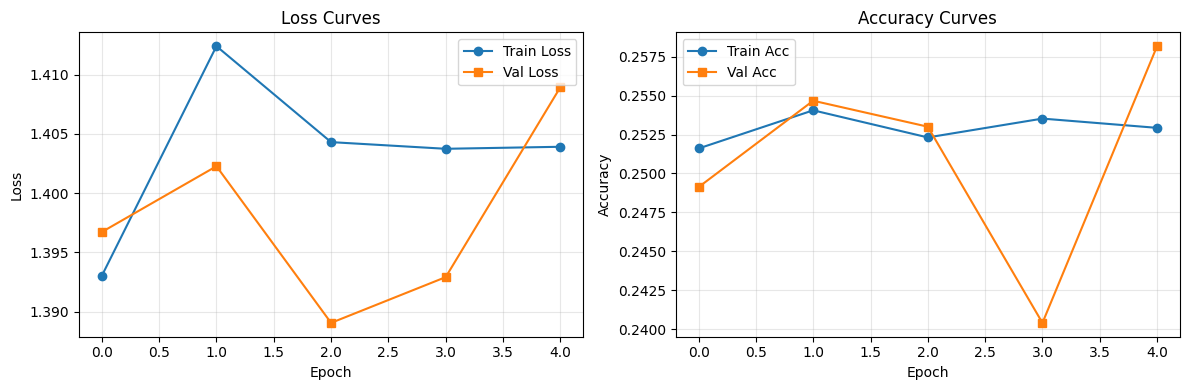


Best validation accuracy: 0.2582


In [30]:
# Plot training curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest validation accuracy: {best_val_acc:.4f}")

In [31]:
# Final test evaluation
print("="*60)
print("FINAL TEST EVALUATION")
print("="*60)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

FINAL TEST EVALUATION

Test Loss:     1.4069
Test Accuracy: 0.2534 (25.34%)


In [32]:
# Per-class accuracy
from collections import defaultdict

print("="*60)
print("PER-CLASS PERFORMANCE")
print("="*60)

model.eval()
class_correct = defaultdict(int)
class_total = defaultdict(int)

with torch.no_grad():
    for texts, labels, lengths in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        
        logits = model(texts)
        predictions = logits.argmax(dim=1)
        
        for pred, label in zip(predictions, labels):
            class_total[label.item()] += 1
            if pred == label:
                class_correct[label.item()] += 1

print(f"\n{'Class':<12} {'Correct':>8} {'Total':>8} {'Accuracy':>10}")
print("-" * 40)
for i, name in enumerate(CLASS_NAMES):
    acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{name:<12} {class_correct[i]:>8} {class_total[i]:>8} {acc:>10.4f}")

PER-CLASS PERFORMANCE

Class         Correct    Total   Accuracy
----------------------------------------
World               0     1900     0.0000
Sports            452     1900     0.2379
Business          997     1900     0.5247
Sci/Tech          477     1900     0.2511


In [33]:
# Sample predictions
print("="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Get a batch from test set
test_texts, test_labels, test_lengths = next(iter(test_loader))
test_texts = test_texts.to(device)

model.eval()
with torch.no_grad():
    logits = model(test_texts)
    probs = torch.softmax(logits, dim=1)
    predictions = logits.argmax(dim=1)

# Show first 5 predictions
for i in range(5):
    true_label = test_labels[i].item()
    pred_label = predictions[i].item()
    confidence = probs[i, pred_label].item()
    
    status = "✓" if true_label == pred_label else "✗"
    
    print(f"\nSample {i+1}: {status}")
    print(f"  True:       {CLASS_NAMES[true_label]}")
    print(f"  Predicted:  {CLASS_NAMES[pred_label]} (confidence: {confidence:.2%})")

SAMPLE PREDICTIONS

Sample 1: ✓
  True:       Business
  Predicted:  Business (confidence: 27.93%)

Sample 2: ✓
  True:       Sci/Tech
  Predicted:  Sci/Tech (confidence: 30.29%)

Sample 3: ✓
  True:       Sci/Tech
  Predicted:  Sci/Tech (confidence: 30.29%)

Sample 4: ✗
  True:       Sci/Tech
  Predicted:  Business (confidence: 40.37%)

Sample 5: ✗
  True:       Sci/Tech
  Predicted:  Sports (confidence: 27.75%)


## 5. Summary

<span style="font-size: 15px;">

**What We Built**

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                    COMPLETE RNN TEXT CLASSIFIER                                  │
└─────────────────────────────────────────────────────────────────────────────────┘

  Raw Text              Preprocessing           RNN Classifier           Output
  ────────              ─────────────           ──────────────           ──────
  "Wall St..."    →    [670,251,...,0,0]   →   Embedding → RNN    →    [z₀,z₁,z₂,z₃]
                         (Step 1)               → FC (Step 2)           → "Business"
```

**Key Takeaways**

| Aspect | Key Point |
|--------|----------|
| Embedding | Maps discrete tokens to learnable dense vectors |
| RNN | Processes sequence left-to-right, maintaining hidden state |
| Classification | Uses final hidden state to predict class |
| Regularization | Dropout prevents overfitting |

**Possible Improvements**

- **LSTM/GRU**: Replace `nn.RNN` with `nn.LSTM` or `nn.GRU` for better long-range dependencies
- **Bidirectional**: Process sequence in both directions
- **Pre-trained embeddings**: Initialize with Word2Vec or GloVe
- **Attention mechanisms**: Weight important words more heavily

</span>

In [34]:
print("="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"\nFinal Results:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f}")
print(f"  Test Accuracy:            {test_acc:.4f}")
print(f"\nModel Parameters: {sum(p.numel() for p in model.parameters()):,}")

TRAINING COMPLETE

Final Results:
  Best Validation Accuracy: 0.2582
  Test Accuracy:            0.2534

Model Parameters: 3,431,684


# Why the Previous Approach Did Not Work?

## 1. Analyzing the Results

<span style="font-size: 15px;">

**1.1 What Went Wrong?**

Looking at our training results, we observe:

| Metric | Observed Value | Expected Value | Interpretation |
|--------|---------------|----------------|----------------|
| Test Accuracy | ~25% | 85-90% | **Random guessing** (4 classes → 25% by chance) |
| Training Accuracy | ~25% | 95%+ | Model isn't learning even on training data |
| Loss | ~1.39 | < 0.5 | Stuck at $-\ln(0.25) = 1.386$ (uniform prediction) |
| Per-class accuracy | World: 0%, Others: ~25% | Balanced | Model collapsed to predicting few classes |

**The model is essentially making random predictions.** This is not a hyperparameter tuning issue—it's a fundamental architectural limitation.

**1.2 The Root Cause: Vanishing Gradients**

The core problem with vanilla RNNs is the **vanishing gradient problem**. Let's understand why mathematically.

Recall the RNN hidden state update:
$$h_t = \tanh(x_t W_{ih}^T + h_{t-1} W_{hh}^T + b)$$

During backpropagation, gradients flow backward through time. The gradient of the loss $\mathcal{L}$ with respect to an early hidden state $h_k$ involves:

$$\frac{\partial \mathcal{L}}{\partial h_k} = \frac{\partial \mathcal{L}}{\partial h_T} \cdot \prod_{t=k+1}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Each factor $\frac{\partial h_t}{\partial h_{t-1}}$ involves:
$$\frac{\partial h_t}{\partial h_{t-1}} = \text{diag}(1 - h_t^2) \cdot W_{hh}$$

where $\text{diag}(1 - h_t^2)$ comes from the $\tanh$ derivative (bounded by 1).

**The Problem**: When we multiply many terms that are typically less than 1:
$$\prod_{t=k+1}^{T} \|\frac{\partial h_t}{\partial h_{t-1}}\| \approx \gamma^{T-k}$$

where $\gamma < 1$ typically. For a sequence of length $T = 64$:
- If $\gamma = 0.9$: gradient shrinks to $0.9^{64} \approx 0.001$ (0.1% of original)
- If $\gamma = 0.5$: gradient shrinks to $0.5^{64} \approx 10^{-19}$ (essentially zero)

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                    VANISHING GRADIENT VISUALIZATION                              │
└─────────────────────────────────────────────────────────────────────────────────┘

Forward pass:
  x₁ → [h₁] → x₂ → [h₂] → ... → x₆₄ → [h₆₄] → Loss

Backward pass (gradient magnitude):
  ████ ← ███ ← ██ ← █ ← ▪ ← · ← · ← · ← · ← ·
  h₁     h₂    h₃   h₄  h₅  ...              h₆₄
  ↑                                            ↑
  Gradient vanished!                      Full gradient

Result: Early tokens (which often contain important context)
        receive almost no gradient signal.
```

**1.3 Why This Matters for Text Classification**

In our AG News task:
- Sequences are 64 tokens long
- Important classification signals can appear anywhere in the text
- The word "Reuters" at position 1 and "stock" at position 60 both matter

With vanishing gradients:
- The embedding layer receives almost no useful gradient updates
- Early words in the sequence are effectively ignored
- The model can only "remember" the last few tokens

**1.4 Other Contributing Factors**

| Factor | Impact |
|--------|--------|
| **No gating mechanism** | Vanilla RNN has no way to selectively remember/forget information |
| **Random initialization** | Embeddings start random; without gradients, they stay random |
| **Sequential processing** | Each step depends on the previous; errors compound |
| **tanh saturation** | When $h_t$ is close to ±1, gradients approach 0 |

</span>

## 2. The Solution: Long Short-Term Memory (LSTM)

<span style="font-size: 15px;">

**2.1 LSTM: Designed to Solve Vanishing Gradients**

The **Long Short-Term Memory (LSTM)** architecture, introduced by Hochreiter & Schmidhuber (1997), was specifically designed to address the vanishing gradient problem. The key innovation is the **cell state** $c_t$—a highway that allows information to flow unchanged across many time steps.

**2.2 LSTM Architecture**

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                              LSTM CELL ARCHITECTURE                              │
└─────────────────────────────────────────────────────────────────────────────────┘

                              Cell State (memory highway)
    c_{t-1} ─────────────────────[×]─────────────[+]─────────────────── c_t
                                  ↑               ↑
                                  │               │
                           ┌─────────────┐  ┌─────────────┐
                           │ Forget Gate │  │ Input Gate  │
                           │   f_t · c   │  │  i_t · g_t  │
                           └─────────────┘  └─────────────┘
                                  ↑               ↑
                            ┌─────┴─────┐   ┌─────┴─────┐
                            │  σ(...)   │   │ σ(.) ⊙    │
                            │           │   │   tanh(.) │
                            └───────────┘   └───────────┘
                                  ↑               ↑
    h_{t-1} ──────────────────────┼───────────────┼───────────────────── 
                                  │               │                     ↓
    x_t ──────────────────────────┴───────────────┴────────────── [Output Gate]
                                                                        ↓
                                                         h_t = o_t ⊙ tanh(c_t)
```

**2.3 The Three Gates**

LSTM uses **three gates** to control information flow:

| Gate | Symbol | Purpose | Equation |
|------|--------|---------|----------|
| **Forget Gate** | $f_t$ | What to forget from cell state | $f_t = \sigma(x_t W_{if}^T + h_{t-1} W_{hf}^T + b_f)$ |
| **Input Gate** | $i_t$ | What new info to store | $i_t = \sigma(x_t W_{ii}^T + h_{t-1} W_{hi}^T + b_i)$ |
| **Output Gate** | $o_t$ | What to output | $o_t = \sigma(x_t W_{io}^T + h_{t-1} W_{ho}^T + b_o)$ |

The candidate cell state:
$$\tilde{c}_t = \tanh(x_t W_{ig}^T + h_{t-1} W_{hg}^T + b_g)$$

**2.4 The Cell State Update (The Key Innovation)**

$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$

This is the **critical equation**. Notice:
- If $f_t \approx 1$ and $i_t \approx 0$: information flows unchanged ($c_t \approx c_{t-1}$)
- Gradients can flow through the cell state with minimal decay
- The network learns **when** to remember and **when** to forget

**2.5 Why LSTM Solves Vanishing Gradients**

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                    GRADIENT FLOW COMPARISON                                      │
└─────────────────────────────────────────────────────────────────────────────────┘

Vanilla RNN (gradients must pass through tanh at every step):
  ∂L/∂h₁ = ∂L/∂h₆₄ × (∂h₆₄/∂h₆₃) × (∂h₆₃/∂h₆₂) × ... × (∂h₂/∂h₁)
                         ↑              ↑                    ↑
                    |tanh'| < 1    |tanh'| < 1          |tanh'| < 1
                    
  Result: Gradient shrinks exponentially → vanishes

LSTM (gradients can flow through cell state highway):
  ∂L/∂c₁ = ∂L/∂c₆₄ × f₆₄ × f₆₃ × ... × f₂
                      ↑      ↑          ↑
                   Can be ≈ 1 when network learns to remember!
                   
  Result: Gradient can flow unimpeded → long-range learning
```

**2.6 LSTM vs RNN: Summary**

| Aspect | Vanilla RNN | LSTM |
|--------|-------------|------|
| Hidden state | $h_t$ only | $h_t$ and $c_t$ (cell state) |
| Gates | None | 3 (forget, input, output) |
| Gradient flow | Through $\tanh$ at each step | Direct through cell state |
| Long-range dependencies | ❌ Poor (vanishing gradients) | ✅ Excellent |
| Parameters | $\sim 4 \times$ fewer | More parameters |
| Typical accuracy on AG News | ~25% (random) | ~85-90% |

</span>

## 3. PyTorch Implementation: nn.RNN vs nn.LSTM

<span style="font-size: 15px;">

**3.1 API Comparison**

PyTorch makes switching from RNN to LSTM straightforward. The APIs are nearly identical:

```python
# Vanilla RNN
nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)

# LSTM
nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
```

**3.2 Key Difference: Output Format**

The main difference is in what the forward pass returns:

| Component | nn.RNN | nn.LSTM |
|-----------|--------|--------|
| **output** | $(B, L, H)$ — hidden states at all time steps | $(B, L, H)$ — same |
| **hidden** | $h_n$: $(N, B, H)$ — final hidden state | $(h_n, c_n)$ — **tuple** of hidden and cell state |

```python
# RNN forward pass
output, h_n = self.rnn(embedded)
hidden = h_n[-1]  # Shape: (B, H)

# LSTM forward pass
output, (h_n, c_n) = self.lstm(embedded)  # Note: tuple unpacking!
hidden = h_n[-1]  # Shape: (B, H)
```

**3.3 Parameter Count Comparison**

LSTM has approximately 4× more parameters than RNN for the same hidden size (due to 4 weight matrices instead of 1):

| Layer | RNN Parameters | LSTM Parameters |
|-------|---------------|----------------|
| Layer 0 input weights | $H \times d$ | $4H \times d$ |
| Layer 0 hidden weights | $H \times H$ | $4H \times H$ |
| Layer 0 biases | $2H$ | $8H$ |

For our configuration ($d = 128$, $H = 256$, 2 layers):
- RNN: ~230K parameters (recurrent layers only)
- LSTM: ~920K parameters (recurrent layers only)

</span>

## 4. Building the LSTM Classifier

<span style="font-size: 15px;">

**4.1 Architecture Overview**

Our LSTM classifier follows the same structure as before, with the RNN layer replaced by LSTM:

```
┌─────────────────────────────────────────────────────────────────────────────────┐
│                         LSTM TEXT CLASSIFIER                                     │
└─────────────────────────────────────────────────────────────────────────────────┘

Input: [670, 251, 1564, ...]             Shape: (B, L) = (64, 64)
              ↓
        ┌───────────┐
        │ Embedding │     nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        └───────────┘
              ↓
Embedded: [e₆₇₀, e₂₅₁, ...]           Shape: (B, L, d) = (64, 64, 128)
              ↓
        ┌───────────┐
        │   LSTM    │     nn.LSTM(embed_dim, hidden_size, num_layers, ...)
        └───────────┘
              ↓
output: [h₀, h₁, ..., h_{L-1}]        Shape: (B, L, H) = (64, 64, 256)
(h_n, c_n): final states              h_n Shape: (N, B, H) = (2, 64, 256)
              ↓
        Extract h_n[-1]               Take last layer's final hidden state
              ↓
Hidden: h_{L-1}                       Shape: (B, H) = (64, 256)
              ↓
        ┌───────────┐
        │  Dropout  │     nn.Dropout(p=0.3) — reduced from 0.5
        └───────────┘
              ↓
        ┌───────────┐
        │  Linear   │     nn.Linear(hidden_size, num_classes)
        └───────────┘
              ↓
Logits: [z₀, z₁, z₂, z₃]              Shape: (B, K) = (64, 4)
```

**4.2 Key Changes from RNN Version**

| Component | RNN Version | LSTM Version | Rationale |
|-----------|-------------|--------------|----------|
| Recurrent layer | `nn.RNN` | `nn.LSTM` | Solves vanishing gradients |
| Forward output | `output, h_n` | `output, (h_n, c_n)` | LSTM returns cell state too |
| Dropout | 0.5 | 0.3 | Less aggressive; LSTM already regularizes |

</span>

In [35]:
class LSTMClassifier(nn.Module):
    """
    LSTM-based text classifier for AG News.
    
    Architecture:
        Embedding → LSTM → Dropout → Linear
    
    Key difference from RNNClassifier:
        - Uses nn.LSTM instead of nn.RNN
        - LSTM returns (h_n, c_n) tuple instead of just h_n
        - Better gradient flow enables learning long-range dependencies
    
    Args:
        vocab_size: Size of vocabulary (for embedding layer)
        embed_dim: Dimension of word embeddings
        hidden_size: Dimension of LSTM hidden states
        num_classes: Number of output classes
        num_layers: Number of stacked LSTM layers
        dropout: Dropout probability
        pad_idx: Index of padding token (for padding_idx in Embedding)
    """
    
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes, 
                 num_layers=1, dropout=0.3, pad_idx=0):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Embedding layer: (B, L) → (B, L, embed_dim)
        # padding_idx=pad_idx ensures padding tokens get zero vectors
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx
        )
        
        # LSTM layer: (B, L, embed_dim) → (B, L, hidden_size), ((num_layers, B, hidden_size), (num_layers, B, hidden_size))
        # Key difference: LSTM has cell state c_t in addition to hidden state h_t
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input/output tensors have batch dimension first
            dropout=dropout if num_layers > 1 else 0  # Dropout between LSTM layers
        )
        
        # Dropout for regularization (reduced from 0.5 to 0.3)
        self.dropout = nn.Dropout(dropout)
        
        # Classification head: (B, hidden_size) → (B, num_classes)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of word indices, shape (B, L)
        
        Returns:
            logits: Class scores, shape (B, num_classes)
        """
        # Step 1: Embed word indices → dense vectors
        # (B, L) → (B, L, embed_dim)
        embedded = self.embedding(x)
        
        # Step 2: Process sequence through LSTM
        # embedded: (B, L, embed_dim)
        # output: (B, L, hidden_size) — hidden states at all time steps
        # h_n: (num_layers, B, hidden_size) — final hidden state per layer
        # c_n: (num_layers, B, hidden_size) — final cell state per layer
        output, (h_n, c_n) = self.lstm(embedded)  # Note: tuple unpacking!
        
        # Step 3: Extract final hidden state from last layer
        # h_n[-1]: (B, hidden_size)
        hidden = h_n[-1]
        
        # Step 4: Apply dropout and classify
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        
        return logits

print("LSTMClassifier class defined")

LSTMClassifier class defined


In [36]:
# Model hyperparameters (same as before, except dropout)
EMBED_DIM = 128      # Dimension of word embeddings
HIDDEN_SIZE = 256    # Dimension of LSTM hidden states
NUM_LAYERS = 2       # Number of stacked LSTM layers
DROPOUT = 0.3        # Reduced dropout (LSTM already provides regularization)
NUM_CLASSES = len(CLASS_NAMES)  # 4 classes

# Instantiate LSTM model
lstm_model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    num_classes=NUM_CLASSES,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(device)

print("="*60)
print("LSTM MODEL CONFIGURATION")
print("="*60)
print(f"\nVocabulary size:  {len(vocab):,}")
print(f"Embedding dim:    {EMBED_DIM}")
print(f"Hidden size:      {HIDDEN_SIZE}")
print(f"Number of layers: {NUM_LAYERS}")
print(f"Dropout:          {DROPOUT}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Device:           {device}")

LSTM MODEL CONFIGURATION

Vocabulary size:  25,002
Embedding dim:    128
Hidden size:      256
Number of layers: 2
Dropout:          0.3
Number of classes: 4
Device:           mps


In [37]:
# Verify LSTM model architecture and count parameters
print("="*60)
print("LSTM MODEL ARCHITECTURE")
print("="*60)
print(lstm_model)

print("\n" + "="*60)
print("PARAMETER COUNT")
print("="*60)

total_params = 0
for name, param in lstm_model.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:45s} {str(param.shape):20s} {num_params:,}")

print(f"\n{'Total':45s} {'':20s} {total_params:,}")
print(f"\nTrainable parameters: {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad):,}")

# Compare with RNN model
rnn_params = 3_431_684  # From previous model
print(f"\n" + "="*60)
print("COMPARISON WITH RNN MODEL")
print("="*60)
print(f"RNN model parameters:  {rnn_params:,}")
print(f"LSTM model parameters: {total_params:,}")
print(f"Increase:              {total_params - rnn_params:,} ({100*(total_params/rnn_params - 1):.1f}% more)")
print(f"\nNote: LSTM has ~4× more recurrent layer parameters due to the 4 gates.")

LSTM MODEL ARCHITECTURE
LSTMClassifier(
  (embedding): Embedding(25002, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

PARAMETER COUNT
embedding.weight                              torch.Size([25002, 128]) 3,200,256
lstm.weight_ih_l0                             torch.Size([1024, 128]) 131,072
lstm.weight_hh_l0                             torch.Size([1024, 256]) 262,144
lstm.bias_ih_l0                               torch.Size([1024])   1,024
lstm.bias_hh_l0                               torch.Size([1024])   1,024
lstm.weight_ih_l1                             torch.Size([1024, 256]) 262,144
lstm.weight_hh_l1                             torch.Size([1024, 256]) 262,144
lstm.bias_ih_l1                               torch.Size([1024])   1,024
lstm.bias_hh_l1                               torch.Size([1024])   1,024
fc.weight                       

In [38]:
# Verify forward pass with a sample batch
print("="*60)
print("FORWARD PASS VERIFICATION")
print("="*60)

# Get a sample batch
sample_texts, sample_labels, sample_lengths = next(iter(train_loader))
sample_texts = sample_texts.to(device)

# Forward pass
lstm_model.eval()
with torch.no_grad():
    sample_logits = lstm_model(sample_texts)

print(f"\nInput shape:  {sample_texts.shape} → (B, L) = ({BATCH_SIZE}, {MAX_LENGTH})")
print(f"Output shape: {sample_logits.shape} → (B, K) = ({BATCH_SIZE}, {NUM_CLASSES})")
print(f"\nSample output (first 3 samples):")
print(sample_logits[:3])
print(f"\nPredicted classes: {sample_logits[:3].argmax(dim=1).tolist()}")
print(f"True classes:      {sample_labels[:3].tolist()}")
print(f"\n✓ LSTM model is ready for training!")

FORWARD PASS VERIFICATION

Input shape:  torch.Size([64, 64]) → (B, L) = (64, 64)
Output shape: torch.Size([64, 4]) → (B, K) = (64, 4)

Sample output (first 3 samples):
tensor([[ 0.0001,  0.0852, -0.0139, -0.0615],
        [ 0.0001,  0.0852, -0.0139, -0.0615],
        [ 0.0001,  0.0852, -0.0139, -0.0616]], device='mps:0')

Predicted classes: [1, 1, 1]
True classes:      [2, 1, 1]

✓ LSTM model is ready for training!
